In [1]:
import mne
from mne.io import concatenate_raws, read_raw_edf
import matplotlib.pyplot as plt
import mne.viz
import os
import os.path as op
from mne.preprocessing import (ICA, create_eog_epochs, create_ecg_epochs,
                               corrmap)
from mne.time_frequency import tfr_multitaper
from mne.stats import permutation_cluster_1samp_test as pcluster_test
from mne.datasets import fetch_fsaverage
from mne import Epochs, EvokedArray, create_info, io, pick_types, read_events
from mne.datasets import sample
from mne.decoding import Vectorizer
from mne.decoding import CSP

import torch
from torcheeg.models import EEGNet
from torcheeg.models import DGCNN
from torcheeg import transforms

import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as signal
import scipy as sc
from matplotlib import cm
import matplotlib.colors as colors

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import StratifiedKFold
from sklearn.multiclass import OneVsRestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBClassifier
import torchaudio

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 


/home/aurelien.stumpf/Development/BCI_Classification/eeg_env/lib/python3.8/site-packages/xgboost/core.py:265: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc 2.28+) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(


In [2]:
import sys 
sys.path.append("/home/aurelien.stumpf/Development/BCI_Classification/")
from eeg_project_package import dataset, models, spectral_analysis, training

In [3]:
import importlib
importlib.reload(dataset)
importlib.reload(training)
importlib.reload(models)
importlib.reload(spectral_analysis)

<module 'eeg_project_package.spectral_analysis' from '/home/aurelien.stumpf/Development/BCI_Classification/eeg_project_package/spectral_analysis.py'>

## Check Loading of Braccio Dataset Files

Number of channels:  64
Number of samples:  64


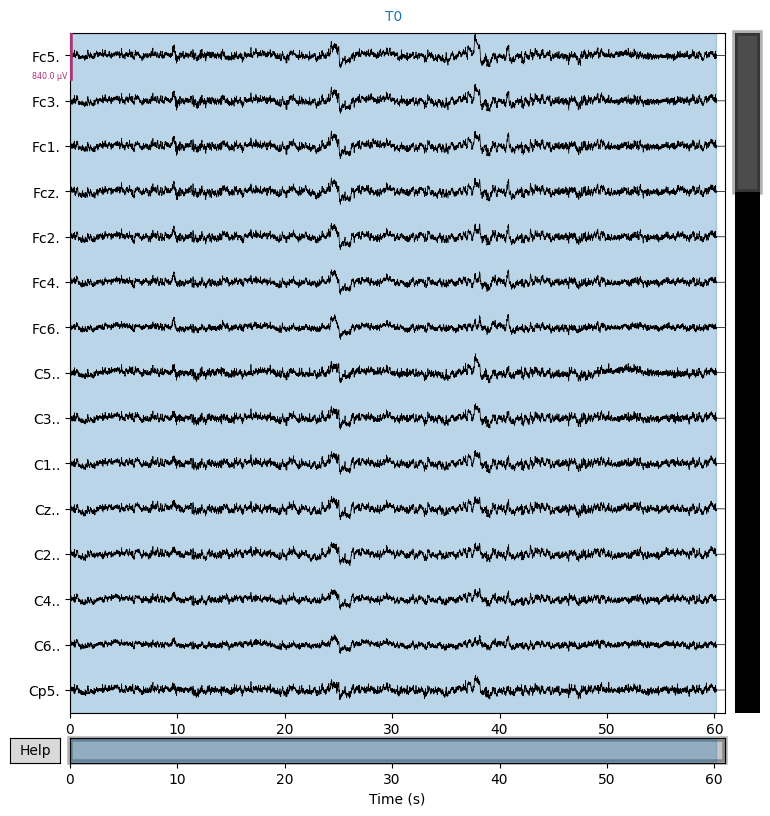

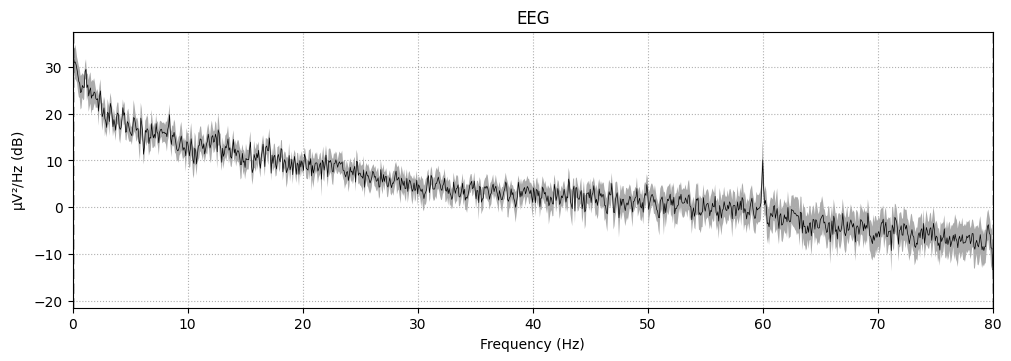

In [4]:
#Define the parameters
subject = 1  # use data from subject 1
runs = [6, 10, 14]  # use only hand and feet motor imagery runs

#Get data and locate in to given path
input_fname1 =  "/home/aurelien.stumpf/Development/Datasets/physionet.org/files/eegmmidb/1.0.0/S001/S001R01.edf"
#Read raw data files where each file contains a run
raws = read_raw_edf(input_fname1, preload=True)
#Combine all loaded runs
#raw_obj = concatenate_raws(raws)
raw_obj = raws

raw_data = raw_obj.get_data()
print("Number of channels: ", str(len(raw_data)))
print("Number of samples: ", str(len(raw_data)))

#Plot epochs & PSD
raw_obj.plot(duration=120, n_channels=15, scalings=dict(eeg=420e-6))
raw_obj.plot_psd(average=True)

# list of all channel names
list_all_ch_names = raw_obj.ch_names

In [5]:
dict_channels = {'Fc5.' : 'FC5',
 'Fc3.' : 'FC3',
 'Fc1.' : 'FC1',
 'Fcz.' : 'FCz',
 'Fc2.' : 'FC2',
 'Fc4.' : 'FC4',
 'Fc6.' : 'FC6',
 'C5..' : 'C5',
 'C3..' : 'C3',
 'C1..' : 'C1',
 'Cz..' : 'Cz',
 'C2..' : 'C2',
 'C4..' : 'C4',
 'C6..' : 'C6',
 'Cp5.' : 'CP5',
 'Cp3.' : 'CP3',
 'Cp1.' : 'CP1',
 'Cpz.' : 'CPz',
 'Cp2.' : 'CP2',
 'Cp4.' : 'CP4',
 'Cp6.' : 'CP6',
 'Fp1.' : 'Fp1',
 'Fpz.' : 'Fpz',
 'Fp2.' : 'Fp2',
 'Af7.' : 'AF7',
 'Af3.' : 'AF3',
 'Afz.' : 'AFz',
 'Af4.' : 'AF4',
 'Af8.' : 'AF8',
 'F7..' : 'F7',
 'F5..' : 'F5',
 'F3..' : 'F3',
 'F1..' : 'F1',
 'Fz..' : 'Fz',
 'F2..' : 'F2',
 'F4..' : 'F4',
 'F6..' : 'F6',
 'F8..' : 'F8',
 'Ft7.' : 'FT7',
 'Ft8.' : 'FT8',
 'T7..' : 'T7',
 'T8..' : 'T8',
 'T9..' : 'T9',
 'T10.' : 'T10',
 'Tp7.' : 'TP7',
 'Tp8.' : 'TP8',
 'P7..' : 'P7',
 'P5..' : 'P5',
 'P3..' : 'P3',
 'P1..' : 'P1',
 'Pz..' : 'Pz',
 'P2..' : 'P2',
 'P4..' : 'P4',
 'P6..' : 'P6',
 'P8..' : 'P8',
 'Po7.' : 'PO7',
 'Po3.' : 'PO3',
 'Poz.' : 'POz',
 'Po4.' : 'PO4',
 'Po8.' : 'PO8',
 'O1..' : 'O1',
 'Oz..' : 'Oz',
 'O2..' : 'O2',
 'Iz..' : 'Iz'}

dict_channels_inv = dict_channels.copy()

# Reverse dict
dict_channels = {v: k for k, v in dict_channels.items()}

## Multi-Subject Classif

In [6]:
# Define the channels
list_name_channels = ["CP1","CP3","CP5","C1","C3","C5","C2","CP2","Cz","FCz","C4","CP4"]
list_idx_channels = [list_all_ch_names.index(dict_channels[ch]) for ch in list_name_channels]

# Define the labels
labels = ['T0', 'T2']

#
parent_folder_path = "/home/aurelien.stumpf/Development/Datasets/physionet.org/files/eegmmidb/1.0.0/"

task_type = "imaginary_right_hand/rest"
if task_type == "imaginary_feet/hand":
    num_runs = [5, 6, 9, 10, 13, 14]
    num_train_subjects = list(range(1, 40))
    num_test_subjects = list(range(64, 85))
elif task_type == "imaginary_left/right":
    num_runs = [4, 8, 12]
    num_train_subjects = list(range(1, 40))
    num_test_subjects = list(range(64, 85))
elif task_type == "imaginary_right_hand/rest":
    num_runs = [4, 8, 12]
    num_train_subjects = list(range(30,109))
    num_test_subjects = list(range(0,30))
num_sessions = []
list_labels = ["T0","T2"]

# Define the parameters of the dataset
feature_type = ["band_psd"]
dict_preprocessing = {"polynomial_degree":None,"tmin":0,"tmax":4,"scale":"standard","seq_length":641}
dict_features = {"type_psd":"welch","fs":500,"nfft":300,"noverlap":150,"nperseg":300,"filter_order":19,"fmin":4,"fmax":30}

torch_trainset = dataset.Physio_Dataset_Multi_Subject(parent_folder_path, num_train_subjects, num_runs, list_idx_channels, list_labels, feature_type, dict_preprocessing, dict_features)
torch_testset = dataset.Physio_Dataset_Multi_Subject(parent_folder_path, num_test_subjects, num_runs, list_idx_channels, list_labels, feature_type, dict_preprocessing, dict_features)
trainloader = torch.utils.data.DataLoader(torch_trainset, batch_size=16, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(torch_testset, batch_size=16, shuffle=True, num_workers=2)

KeyboardInterrupt: 

In [5]:
X = trainset.features["band_psd"]
labels = trainset.labels

# Create classification pipeline
lda = LinearDiscriminantAnalysis()
csp = CSP(n_components=10, reg=None, log=True, norm_trace=False)
clf = make_pipeline(csp, lda)

# Cross validator
cv = StratifiedKFold(n_splits=8, shuffle=True, random_state=42)

# Do cross-validation
preds = np.empty(len(labels))
for train, test in cv.split(X, labels):
    clf.fit(X[train], labels[train])
    preds[test] = clf.predict(X[test])

# Classification report
print(classification_report(labels, preds))

              precision    recall  f1-score   support

         0.0       0.60      0.57      0.58        70
         1.0       0.59      0.61      0.60        70

    accuracy                           0.59       140
   macro avg       0.59      0.59      0.59       140
weighted avg       0.59      0.59      0.59       140



# EEGNet

In [19]:
torch_trainset.transform_dataset_numpy_to_torch()
torch_trainset.features["time"] = torch_trainset.features["time"].unsqueeze(1)
torch_testset.transform_dataset_numpy_to_torch()
torch_testset.features["time"] = torch_testset.features["time"].unsqueeze(1)
trainloader = torch.utils.data.DataLoader(torch_trainset, batch_size=16, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(torch_testset, batch_size=16, shuffle=True, num_workers=2)

In [20]:
torch_trainset.features["time"].shape

torch.Size([5102, 1, 12, 641])

In [23]:
feature_type = "time"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = torch.nn.CrossEntropyLoss()
model = EEGNet(chunk_size=641,
               num_electrodes=12,
               dropout=0.25,
               kernel_1=50,
               kernel_2=25,
               F1=10,
               F2=16,
               D=2,
               num_classes=2)
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
#scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[20, 50], gamma=0.1)
scheduler = torch.optim.lr_scheduler.MultiplicativeLR(optimizer, lr_lambda=lambda epoch: 0.97)
scheduler_dict = {"MultiplicativeLR" : scheduler}
logs = training.train_model(model, trainloader, testloader, device, criterion, feature_type, 31, optimizer, scheduler_dict, print_epoch = 5)

Epoch 0:   0%|          | 0/319 [00:00<?, ?batch/s]

Epoch 0
lr:  0.01
-------------------------


Train set: Avg. loss: 0.0433, Balanced Accuracy: 0.4774579703807831 (48%)
Test set: Avg. loss: 0.0434, Balanced Accuracy: 0.465032696723938 (47%)
-------------------------


Epoch 5:   0%|          | 0/319 [00:00<?, ?batch/s]

Epoch 5
lr:  0.008587340256999998
-------------------------
Train set: Avg. loss: 0.0313, Balanced Accuracy: 0.6851121187210083 (69%)
Test set: Avg. loss: 0.0317, Balanced Accuracy: 0.7137942910194397 (71%)
-------------------------


Epoch 10:   0%|          | 0/319 [00:00<?, ?batch/s]

Epoch 10
lr:  0.0073742412689492805
-------------------------
Train set: Avg. loss: 0.0336, Balanced Accuracy: 0.6004692316055298 (60%)
Test set: Avg. loss: 0.0350, Balanced Accuracy: 0.6103827953338623 (61%)
-------------------------


Epoch 15:   0%|          | 0/319 [00:00<?, ?batch/s]

Epoch 15
lr:  0.006332511891367892
-------------------------
Train set: Avg. loss: 0.0267, Balanced Accuracy: 0.7426204681396484 (74%)
Test set: Avg. loss: 0.0288, Balanced Accuracy: 0.7376415729522705 (74%)
-------------------------


Epoch 20:   0%|          | 0/319 [00:00<?, ?batch/s]

Epoch 20
lr:  0.005437943429267469
-------------------------
Train set: Avg. loss: 0.0268, Balanced Accuracy: 0.735637903213501 (74%)
Test set: Avg. loss: 0.0288, Balanced Accuracy: 0.7369292974472046 (74%)
-------------------------


Epoch 25:   0%|          | 0/319 [00:00<?, ?batch/s]

Epoch 25
lr:  0.004669747052543716
-------------------------
Train set: Avg. loss: 0.0254, Balanced Accuracy: 0.7870384454727173 (79%)
Test set: Avg. loss: 0.0283, Balanced Accuracy: 0.7715224027633667 (77%)
-------------------------


Epoch 30:   0%|          | 0/319 [00:00<?, ?batch/s]

Epoch 30
lr:  0.004010070685431574
-------------------------
Train set: Avg. loss: 0.0251, Balanced Accuracy: 0.7508774995803833 (75%)
Test set: Avg. loss: 0.0295, Balanced Accuracy: 0.7276259660720825 (73%)
-------------------------


Epoch 30: 100%|██████████| 319/319 [00:05<00:00, 58.09batch/s, accuracy=0.806, loss=0.0271] 


In [9]:
for param in model.parameters():
    print(param.data.shape)
    time_filters = param.data.cpu().numpy()
    break

torch.Size([10, 1, 1, 50])


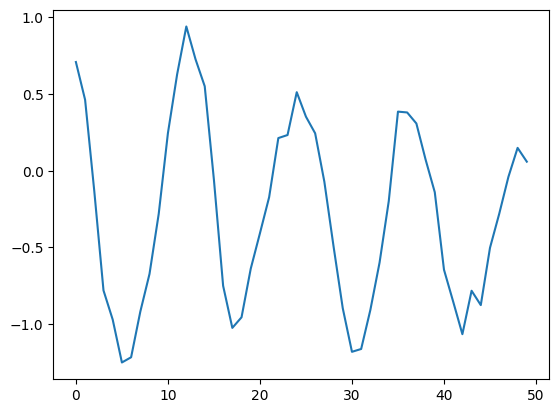

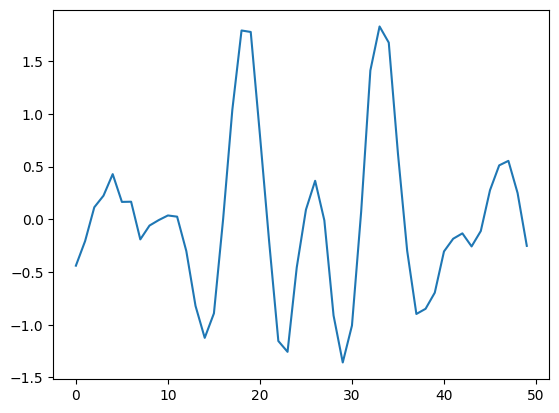

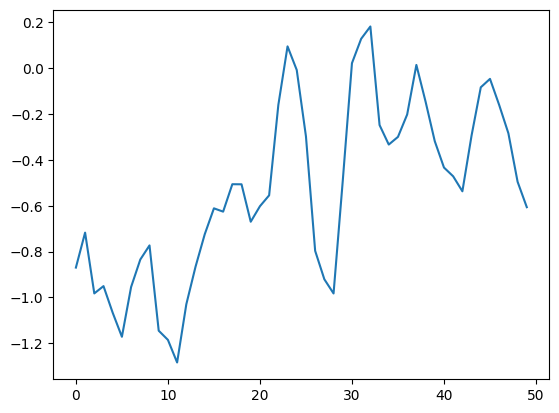

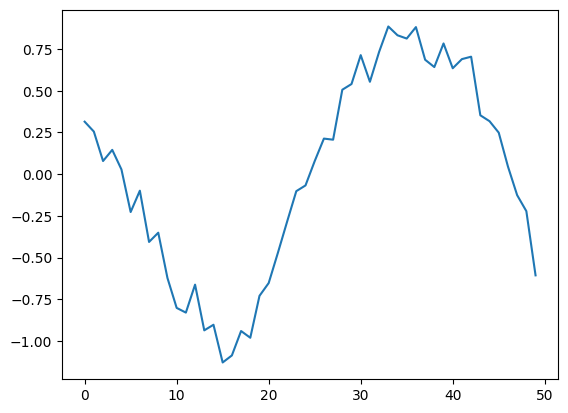

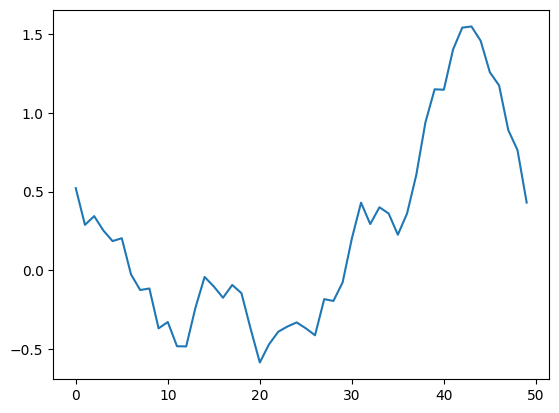

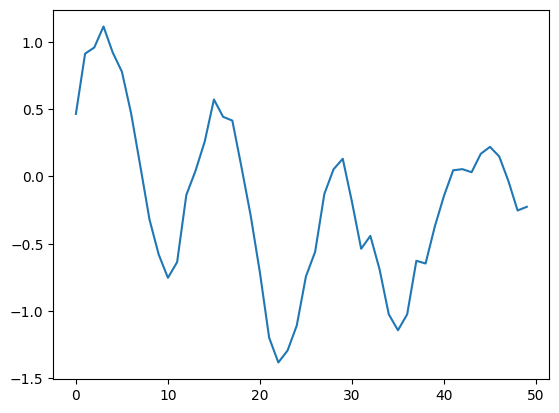

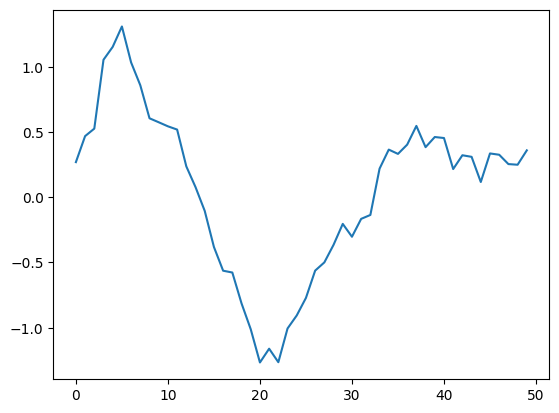

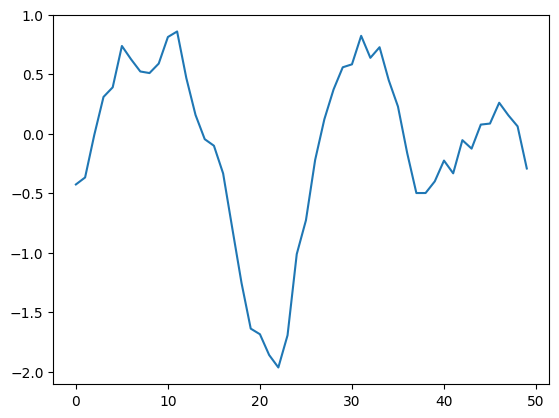

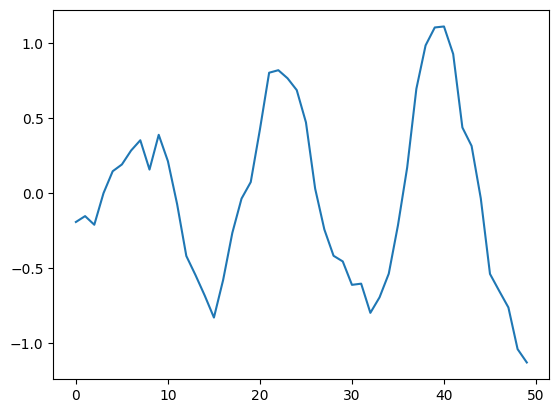

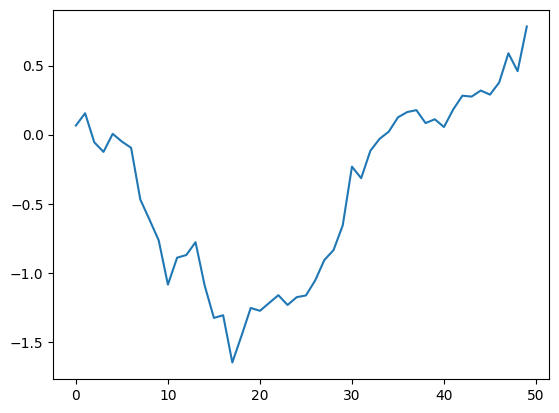

In [10]:
time_filters = time_filters.reshape(10, 50)
for i in range(10):
    plt.plot(time_filters[i])
    plt.show()

In [112]:
torch.save(model.state_dict(), "/home/aurelien.stumpf/Development/BCI_Classification/models/physionet/EEGNet.pth")

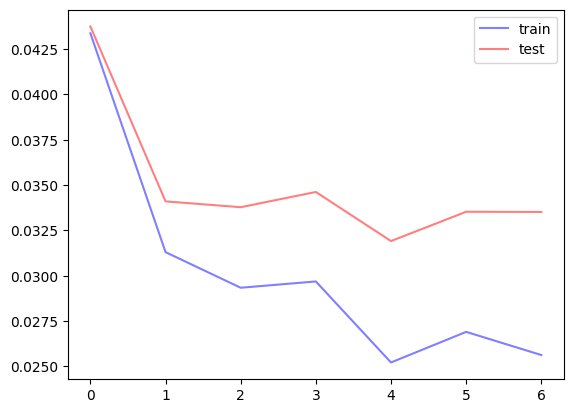

In [114]:
plt.plot(logs["train_losses"], label="train", color="blue", alpha=0.5)
plt.plot(logs["test_losses"], label="test", color="red", alpha=0.5)
plt.legend()
plt.show()

In [125]:
dict_channels_inv.values()

dict_values(['FC5', 'FC3', 'FC1', 'FCz', 'FC2', 'FC4', 'FC6', 'C5', 'C3', 'C1', 'Cz', 'C2', 'C4', 'C6', 'CP5', 'CP3', 'CP1', 'CPz', 'CP2', 'CP4', 'CP6', 'Fp1', 'Fpz', 'Fp2', 'AF7', 'AF3', 'AFz', 'AF4', 'AF8', 'F7', 'F5', 'F3', 'F1', 'Fz', 'F2', 'F4', 'F6', 'F8', 'FT7', 'FT8', 'T7', 'T8', 'T9', 'T10', 'TP7', 'TP8', 'P7', 'P5', 'P3', 'P1', 'Pz', 'P2', 'P4', 'P6', 'P8', 'PO7', 'PO3', 'POz', 'PO4', 'PO8', 'O1', 'Oz', 'O2', 'Iz'])

In [26]:
montage = mne.channels.make_standard_montage('standard_1020')
list_channels_std = list(dict_channels_inv.values())

def get_positions_from_channel_list(channel_list, montage):
    dict_positions = montage.get_positions()["ch_pos"]
    positions = []
    for channel in channel_list:
        positions.append(dict_positions[channel])
    return positions

ch_positions = np.array(get_positions_from_channel_list(list_channels_std, montage))

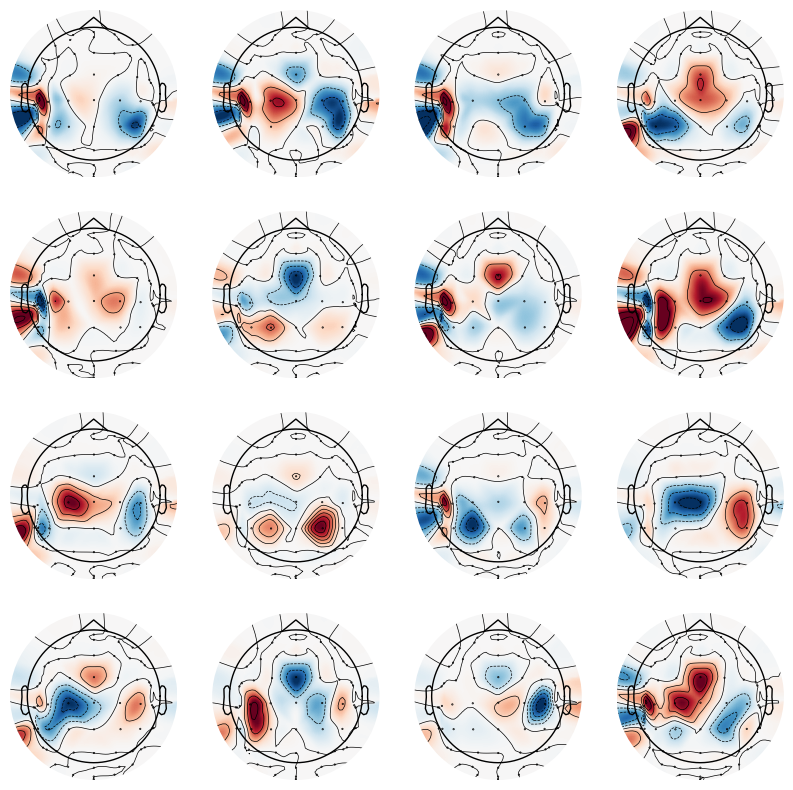

In [132]:
fig, ax = plt.subplots(4, 4, figsize=(10, 10))

for i in range(4):
    for j in range(4):
        spatial_map_12 = model.block1[2].weight.data[i + 4 * j].cpu().numpy().flatten()
        spatial_map_64 = np.zeros(64)
        spatial_map_64[list_idx_channels] = spatial_map_12
        mne.viz.plot_topomap(
            spatial_map_64,
            ch_positions[:, :2],
            show=False,
            axes=ax[i, j]
        )

plt.show()

# Corr

In [39]:
importlib.reload(dataset)
importlib.reload(training)
importlib.reload(models)

<module 'eeg_project_package.models' from '/home/aurelien.stumpf/Development/BCI_Classification/eeg_project_package/models.py'>

In [212]:
torch_trainset.transform_dataset_numpy_to_torch()
torch_trainset.features["time"] = torch_trainset.features["time"].squeeze(1)
torch_testset.transform_dataset_numpy_to_torch()
torch_testset.features["time"] = torch_testset.features["time"].squeeze(1)

In [34]:
torch_trainset.features["time"].shape

torch.Size([2623, 1, 12, 641])

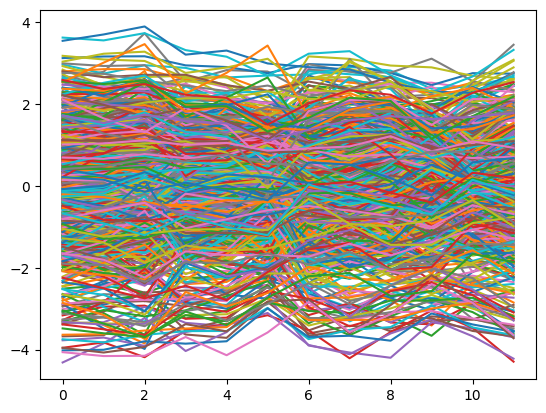

In [35]:
plt.plot(torch_trainset.features["time"][0,0,:].cpu().numpy())
plt.show()

In [40]:
feature_type = "time"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = torch.nn.CrossEntropyLoss()
model = models.Corr_MLP(n_channels = 12, n_filters = 100, nperseg = 100, noverlap = 50, seq_length = 641, layer_size_list = [100,2], F1 = 16, F2 = 32, pool_size = 7, non_linearity="relu", initialization="xavier")
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
scheduler1 = torch.optim.lr_scheduler.MultiplicativeLR(optimizer, lr_lambda=lambda epoch: 0.95)
scheduler2 = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5)
scheduler_dict = {"ReduceLROnPlateau":scheduler2, "MultiplicativeLR":scheduler1, "ReduceLROnPlateau":scheduler2}
logs = training.train_model(model, trainloader, testloader, device, criterion, feature_type, 101, optimizer, scheduler_dict, print_epoch = 10)

Epoch 0:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 0
lr:  0.1
-------------------------


Epoch 0:   0%|          | 0/164 [00:00<?, ?batch/s]


torch.Size([16, 32, 641])


RuntimeError: einsum(): subscript k has size 32 for operand 1 which does not broadcast with previously seen size 641

torch.Size([100, 100])


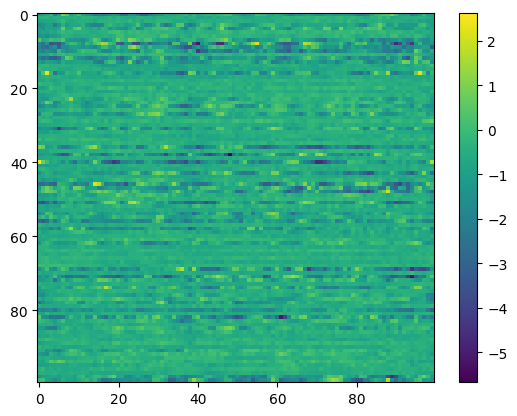

In [217]:
for param in model.parameters():
    print(param.data.shape)
    time_filters = param.data.cpu().numpy()
    break

plt.imshow(time_filters, aspect='auto')
plt.colorbar()
plt.show()

# Quadra

In [41]:
importlib.reload(dataset)
importlib.reload(training)
importlib.reload(models)

<module 'eeg_project_package.models' from '/home/aurelien.stumpf/Development/BCI_Classification/eeg_project_package/models.py'>

In [223]:
feature_type = "time"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = torch.nn.CrossEntropyLoss()
model = models.Quadra_MLP(n_channels = 12, n_filters = 20, nperseg = 300, noverlap = 150, seq_length = 641, layer_size_list = [100,2], non_linearity="relu", initialization="xavier")
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
scheduler1 = torch.optim.lr_scheduler.MultiplicativeLR(optimizer, lr_lambda=lambda epoch: 0.95)
scheduler2 = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5)
scheduler_dict = {"ReduceLROnPlateau":scheduler2, "MultiplicativeLR":scheduler1, "ReduceLROnPlateau":scheduler2}
logs = training.train_model(model, trainloader, testloader, device, criterion, feature_type, 101, optimizer, scheduler_dict, print_epoch = 10)

Epoch 0:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 0
lr:  0.01
-------------------------


Train set: Avg. loss: 0.0465, Balanced Accuracy: 0.5137448310852051 (51%)
Test set: Avg. loss: 0.0485, Balanced Accuracy: 0.4969741404056549 (50%)
-------------------------


Epoch 10:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 10
lr:  0.005987369392383786
-------------------------
Train set: Avg. loss: 0.0393, Balanced Accuracy: 0.5051843523979187 (51%)
Test set: Avg. loss: 0.0418, Balanced Accuracy: 0.5005438327789307 (50%)
-------------------------


Epoch 20:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 20
lr:  0.0035848592240854188
-------------------------
Train set: Avg. loss: 0.0395, Balanced Accuracy: 0.5028801560401917 (50%)
Test set: Avg. loss: 0.0401, Balanced Accuracy: 0.49947088956832886 (50%)
-------------------------


Epoch 28:  28%|██▊       | 46/164 [00:00<00:02, 57.60batch/s, accuracy=0.673, loss=0.0111] 
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f344001c790>
Traceback (most recent call last):
  File "/home/aurelien.stumpf/Development/BCI_Classification/eeg_env/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/home/aurelien.stumpf/Development/BCI_Classification/eeg_env/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1443, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.8/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
  File "/usr/lib/python3.8/multiprocessing/popen_fork.py", line 44, in wait
    if not wait([self.sentinel], timeout):
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 931, in wait
    ready = selector.select(timeout)
  File "/usr/lib/python3.8/selectors.py", lin

KeyboardInterrupt: 

# Transformer

In [224]:
import importlib
importlib.reload(dataset)
importlib.reload(training)
importlib.reload(models)

<module 'eeg_project_package.models' from '/home/aurelien.stumpf/Development/BCI_Classification/eeg_project_package/models.py'>

In [230]:
torch_trainset.transform_dataset_numpy_to_torch()
torch_trainset.features["time"] = torch_trainset.features["time"].transpose(1,2)
torch_testset.transform_dataset_numpy_to_torch()
torch_testset.features["time"] = torch_testset.features["time"].transpose(1,2)
trainloader = torch.utils.data.DataLoader(torch_trainset, batch_size=16, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(torch_testset, batch_size=16, shuffle=True, num_workers=2)

In [42]:
feature_type = "time"
src_vocab_size = 12
layer_size_list = [10,2]
d_model = 20
num_heads = 10
num_layers = 2
d_ff = 20
nperseg = 200
noverlap = 100
dropout = 0
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = torch.nn.CrossEntropyLoss()
model = models.Transformer(src_vocab_size, layer_size_list, d_model, num_heads, num_layers, d_ff, nperseg, noverlap, dropout)
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler1 = torch.optim.lr_scheduler.MultiplicativeLR(optimizer, lr_lambda=lambda epoch: 0.95)
scheduler2 = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5)
scheduler_dict = {"ReduceLROnPlateau":scheduler2, "MultiplicativeLR":scheduler1}
logs = training.train_model(model, trainloader, testloader, device, criterion, feature_type, 101, optimizer, scheduler_dict, print_epoch = 10)

Epoch 0:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 0
lr:  0.001
-------------------------


Epoch 0:   0%|          | 0/164 [00:00<?, ?batch/s]


ValueError: too many values to unpack (expected 3)

# ATCNet

In [148]:
import importlib
importlib.reload(dataset)
importlib.reload(training)
importlib.reload(models)

<module 'eeg_project_package.models' from '/home/aurelien.stumpf/Development/BCI_Classification/eeg_project_package/models.py'>

In [145]:
from torcheeg.models import ATCNet

In [13]:
torch_trainset.transform_dataset_numpy_to_torch()
torch_trainset.features["time"] = torch_trainset.features["time"].squeeze(1)
torch_testset.transform_dataset_numpy_to_torch()
torch_testset.features["time"] = torch_testset.features["time"].squeeze(1)
trainloader = torch.utils.data.DataLoader(torch_trainset, batch_size=16, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(torch_testset, batch_size=16, shuffle=True, num_workers=2)

In [12]:
torch_trainset.features["time"].shape

torch.Size([5042, 1, 1, 12, 641])

In [24]:
feature_type = "time"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = torch.nn.CrossEntropyLoss()
model = models.ATCNet(in_channels=1,
               num_classes=2,
               num_windows=5,
               num_electrodes=12,
               chunk_size=641,
               filter_size=50,)
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler1 = torch.optim.lr_scheduler.MultiplicativeLR(optimizer, lr_lambda=lambda epoch: 0.95)
scheduler2 = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5)
scheduler_dict = {"MultiplicativeLR":scheduler1} #, "ReduceLROnPlateau":scheduler2}
logs = training.train_model(model, trainloader, testloader, device, criterion, feature_type, 101, optimizer, scheduler_dict, print_epoch = 1)

Epoch 0:   0%|          | 0/319 [00:00<?, ?batch/s]

Epoch 0
lr:  0.001
-------------------------
Train set: Avg. loss: 0.0436, Balanced Accuracy: 0.49626627564430237 (50%)
Test set: Avg. loss: 0.0436, Balanced Accuracy: 0.5093935132026672 (51%)
-------------------------


Epoch 1:   0%|          | 0/319 [00:00<?, ?batch/s]

Epoch 1
lr:  0.00095
-------------------------
Train set: Avg. loss: 0.0342, Balanced Accuracy: 0.7064461708068848 (71%)
Test set: Avg. loss: 0.0338, Balanced Accuracy: 0.726064920425415 (73%)
-------------------------


Epoch 2:   0%|          | 0/319 [00:00<?, ?batch/s]

Epoch 2
lr:  0.0009025
-------------------------
Train set: Avg. loss: 0.0329, Balanced Accuracy: 0.7368427515029907 (74%)
Test set: Avg. loss: 0.0324, Balanced Accuracy: 0.7608637809753418 (76%)
-------------------------


Epoch 3:   0%|          | 0/319 [00:00<?, ?batch/s]

Epoch 3
lr:  0.000857375
-------------------------
Train set: Avg. loss: 0.0321, Balanced Accuracy: 0.7277892827987671 (73%)
Test set: Avg. loss: 0.0323, Balanced Accuracy: 0.7331286668777466 (73%)
-------------------------


Epoch 4:   0%|          | 0/319 [00:00<?, ?batch/s]

Epoch 4
lr:  0.0008145062499999999
-------------------------
Train set: Avg. loss: 0.0326, Balanced Accuracy: 0.7426129579544067 (74%)
Test set: Avg. loss: 0.0324, Balanced Accuracy: 0.7628257274627686 (76%)
-------------------------


Epoch 5:   0%|          | 0/319 [00:00<?, ?batch/s]

Epoch 5
lr:  0.0007737809374999998
-------------------------
Train set: Avg. loss: 0.0313, Balanced Accuracy: 0.7573095560073853 (76%)
Test set: Avg. loss: 0.0316, Balanced Accuracy: 0.7626484036445618 (76%)
-------------------------


Epoch 6:   0%|          | 0/319 [00:00<?, ?batch/s]

Epoch 6
lr:  0.0007350918906249997
-------------------------
Train set: Avg. loss: 0.0309, Balanced Accuracy: 0.7778528928756714 (78%)
Test set: Avg. loss: 0.0317, Balanced Accuracy: 0.7708486318588257 (77%)
-------------------------


Epoch 7:   0%|          | 0/319 [00:00<?, ?batch/s]

Epoch 7
lr:  0.0006983372960937497
-------------------------
Train set: Avg. loss: 0.0308, Balanced Accuracy: 0.7851728796958923 (79%)
Test set: Avg. loss: 0.0317, Balanced Accuracy: 0.772895336151123 (77%)
-------------------------


Epoch 8:   0%|          | 0/319 [00:00<?, ?batch/s]

Epoch 8
lr:  0.0006634204312890621
-------------------------
Train set: Avg. loss: 0.0305, Balanced Accuracy: 0.7875221371650696 (79%)
Test set: Avg. loss: 0.0321, Balanced Accuracy: 0.7663202881813049 (77%)
-------------------------


Epoch 9:   0%|          | 0/319 [00:00<?, ?batch/s]

Epoch 9
lr:  0.000630249409724609
-------------------------
Train set: Avg. loss: 0.0301, Balanced Accuracy: 0.7874048352241516 (79%)
Test set: Avg. loss: 0.0316, Balanced Accuracy: 0.7619823217391968 (76%)
-------------------------


Epoch 10:   0%|          | 0/319 [00:00<?, ?batch/s]

Epoch 10
lr:  0.0005987369392383785
-------------------------
Train set: Avg. loss: 0.0300, Balanced Accuracy: 0.7843227982521057 (78%)
Test set: Avg. loss: 0.0317, Balanced Accuracy: 0.7553841471672058 (76%)
-------------------------


Epoch 11:   0%|          | 0/319 [00:00<?, ?batch/s]

Epoch 11
lr:  0.0005688000922764595
-------------------------
Train set: Avg. loss: 0.0300, Balanced Accuracy: 0.792043924331665 (79%)
Test set: Avg. loss: 0.0313, Balanced Accuracy: 0.7767037153244019 (78%)
-------------------------


Epoch 12:   0%|          | 0/319 [00:00<?, ?batch/s]

Epoch 12
lr:  0.0005403600876626365
-------------------------
Train set: Avg. loss: 0.0294, Balanced Accuracy: 0.798531174659729 (80%)
Test set: Avg. loss: 0.0313, Balanced Accuracy: 0.763828694820404 (76%)
-------------------------


Epoch 13:   0%|          | 0/319 [00:00<?, ?batch/s]

Epoch 13
lr:  0.0005133420832795047
-------------------------
Train set: Avg. loss: 0.0292, Balanced Accuracy: 0.8071169853210449 (81%)
Test set: Avg. loss: 0.0311, Balanced Accuracy: 0.7774545550346375 (78%)
-------------------------


Epoch 14:   0%|          | 0/319 [00:00<?, ?batch/s]

Epoch 14
lr:  0.00048767497911552944
-------------------------
Train set: Avg. loss: 0.0289, Balanced Accuracy: 0.8180462121963501 (82%)
Test set: Avg. loss: 0.0313, Balanced Accuracy: 0.7813553810119629 (78%)
-------------------------


Epoch 15:   0%|          | 0/319 [00:00<?, ?batch/s]

Epoch 15
lr:  0.00046329123015975297
-------------------------
Train set: Avg. loss: 0.0288, Balanced Accuracy: 0.8136128187179565 (81%)
Test set: Avg. loss: 0.0313, Balanced Accuracy: 0.7704500555992126 (77%)
-------------------------


Epoch 16:   0%|          | 0/319 [00:00<?, ?batch/s]

Epoch 16
lr:  0.0004401266686517653
-------------------------
Train set: Avg. loss: 0.0288, Balanced Accuracy: 0.8169223070144653 (82%)
Test set: Avg. loss: 0.0312, Balanced Accuracy: 0.7692466378211975 (77%)
-------------------------


Epoch 17:   0%|          | 0/319 [00:00<?, ?batch/s]

Epoch 17
lr:  0.00041812033521917703
-------------------------
Train set: Avg. loss: 0.0286, Balanced Accuracy: 0.828774094581604 (83%)
Test set: Avg. loss: 0.0318, Balanced Accuracy: 0.7710182666778564 (77%)
-------------------------


Epoch 18:   0%|          | 0/319 [00:00<?, ?batch/s]

Epoch 18
lr:  0.00039721431845821814
-------------------------
Train set: Avg. loss: 0.0281, Balanced Accuracy: 0.8210429549217224 (82%)
Test set: Avg. loss: 0.0307, Balanced Accuracy: 0.7746028900146484 (77%)
-------------------------


Epoch 19:   0%|          | 0/319 [00:00<?, ?batch/s]

Epoch 19
lr:  0.0003773536025353072
-------------------------
Train set: Avg. loss: 0.0281, Balanced Accuracy: 0.8287336826324463 (83%)
Test set: Avg. loss: 0.0314, Balanced Accuracy: 0.7657983303070068 (77%)
-------------------------


Epoch 20:   0%|          | 0/319 [00:00<?, ?batch/s]

Epoch 20
lr:  0.0003584859224085418
-------------------------
Train set: Avg. loss: 0.0280, Balanced Accuracy: 0.83054119348526 (83%)
Test set: Avg. loss: 0.0310, Balanced Accuracy: 0.7778068780899048 (78%)
-------------------------


Epoch 21:   0%|          | 0/319 [00:00<?, ?batch/s]

Epoch 21
lr:  0.0003405616262881147
-------------------------
Train set: Avg. loss: 0.0284, Balanced Accuracy: 0.8338303565979004 (83%)
Test set: Avg. loss: 0.0317, Balanced Accuracy: 0.7779764533042908 (78%)
-------------------------


Epoch 22:   0%|          | 0/319 [00:00<?, ?batch/s]

Epoch 22
lr:  0.00032353354497370894
-------------------------
Train set: Avg. loss: 0.0279, Balanced Accuracy: 0.8387388586997986 (84%)
Test set: Avg. loss: 0.0312, Balanced Accuracy: 0.7824816703796387 (78%)
-------------------------


Epoch 23:   0%|          | 0/319 [00:00<?, ?batch/s]

Epoch 23
lr:  0.00030735686772502346
-------------------------
Train set: Avg. loss: 0.0279, Balanced Accuracy: 0.8417644500732422 (84%)
Test set: Avg. loss: 0.0314, Balanced Accuracy: 0.7798459529876709 (78%)
-------------------------


Epoch 24:   0%|          | 0/319 [00:00<?, ?batch/s]

Epoch 24
lr:  0.00029198902433877225
-------------------------
Train set: Avg. loss: 0.0275, Balanced Accuracy: 0.8450421094894409 (85%)
Test set: Avg. loss: 0.0310, Balanced Accuracy: 0.7793702483177185 (78%)
-------------------------


Epoch 24:  47%|████▋     | 151/319 [00:11<00:13, 12.85batch/s, accuracy=0.858, loss=0.0134] 


KeyboardInterrupt: 

In [25]:
li_eegnet = np.array([0.75, 0.75, 0.77])
li_atcnet = np.array([0.77, 0.76, 0.78])
print(np.mean(li_eegnet), np.mean(li_atcnet))
print(np.std(li_eegnet), np.std(li_atcnet))

0.7566666666666667 0.77
0.009428090415820642 0.008164965809277268


In [24]:
model

ATCNet(
  (conv_block): Sequential(
    (0): Conv2d(1, 16, kernel_size=(1, 321), stride=(1, 1), padding=same, bias=False)
    (1): BatchNorm2d(16, eps=False, momentum=0.1, affine=True, track_running_stats=True)
    (2): Conv2d(16, 32, kernel_size=(12, 1), stride=(1, 1), groups=16)
    (3): BatchNorm2d(32, eps=False, momentum=0.1, affine=True, track_running_stats=True)
    (4): ELU(alpha=1.0)
    (5): AvgPool2d(kernel_size=(1, 8), stride=(1, 8), padding=0)
    (6): Dropout2d(p=0.1, inplace=False)
    (7): Conv2d(32, 32, kernel_size=(1, 16), stride=(1, 1), padding=same, bias=False)
    (8): BatchNorm2d(32, eps=False, momentum=0.1, affine=True, track_running_stats=True)
    (9): ELU(alpha=1.0)
    (10): AvgPool2d(kernel_size=(1, 7), stride=(1, 7), padding=0)
    (11): Dropout2d(p=0.1, inplace=False)
  )
  (msa0): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=32, out_features=32, bias=True)
  )
  (msa_drop0): Dropout(p=0.3, inplace=False)
  (tcn0): Sequent

torch.Size([16, 1, 1, 50])


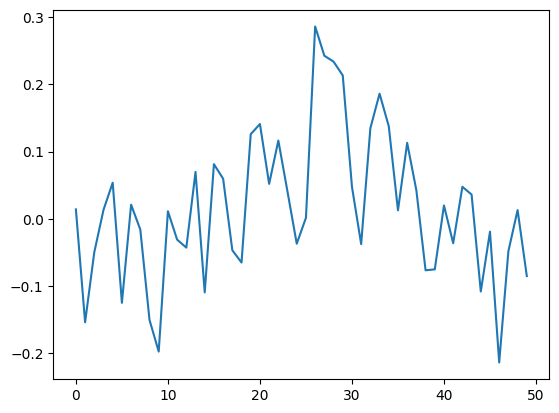

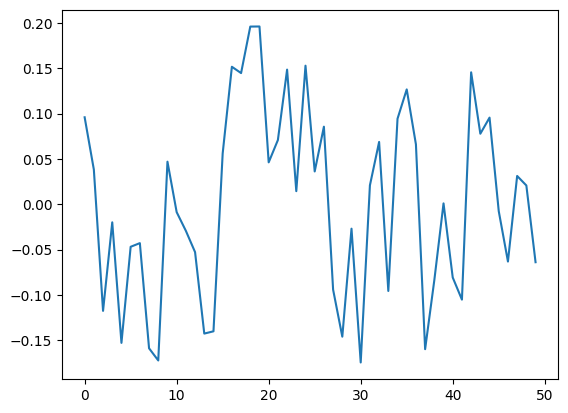

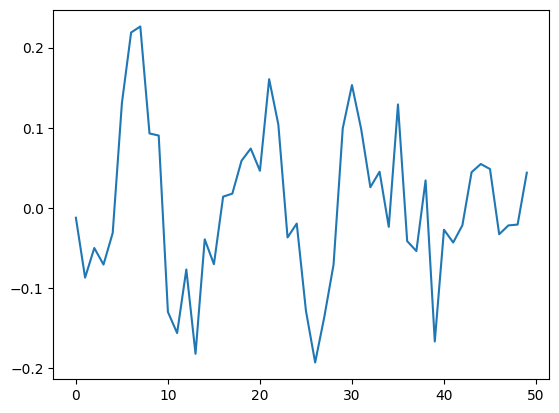

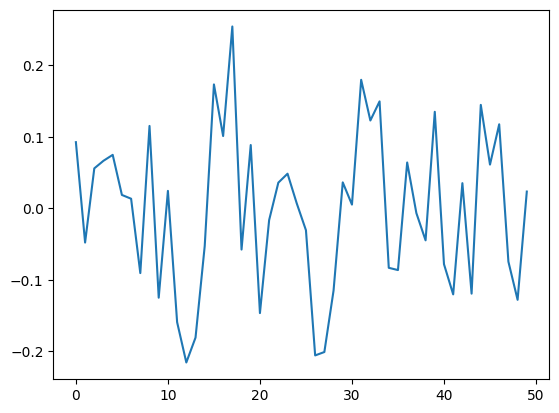

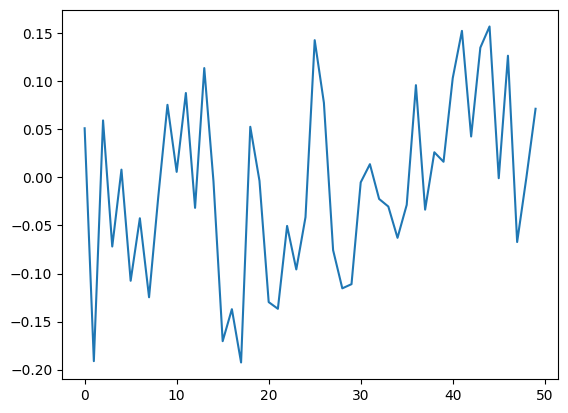

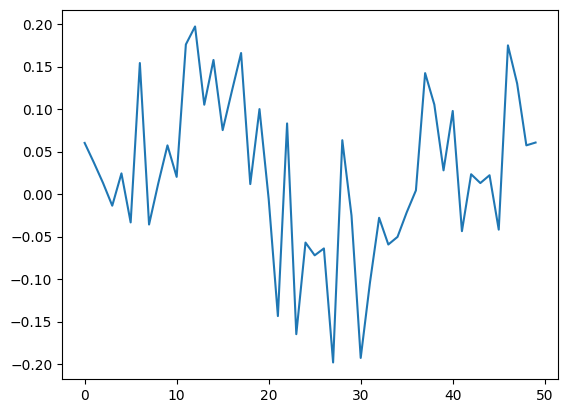

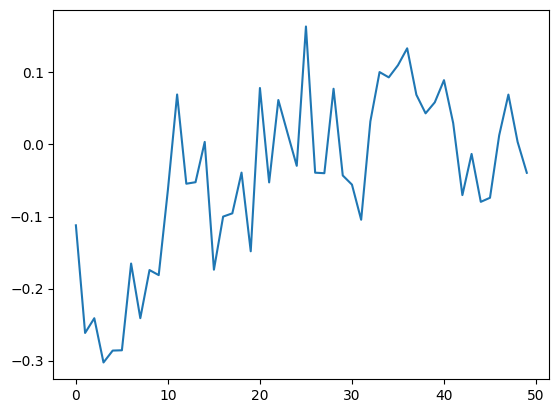

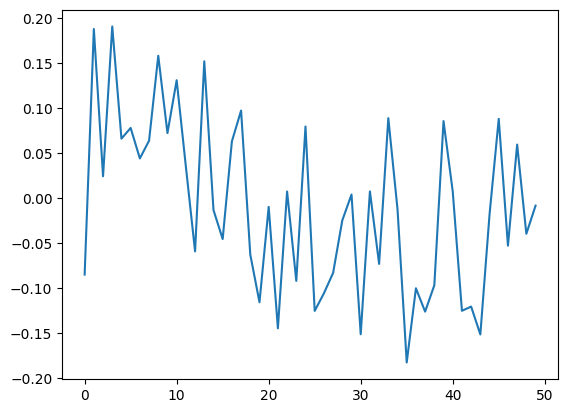

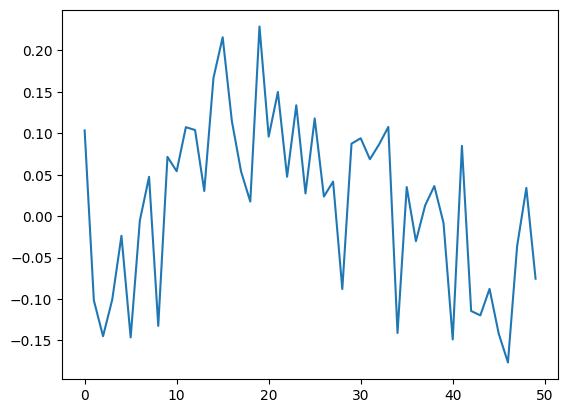

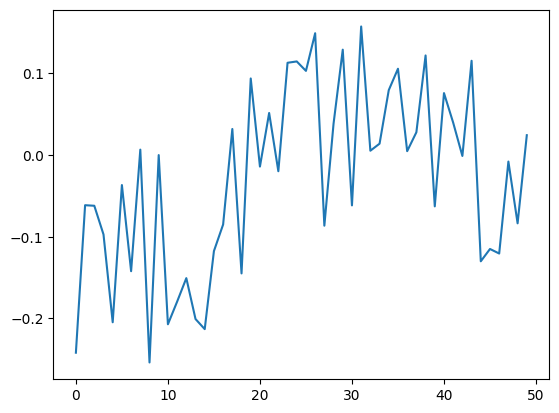

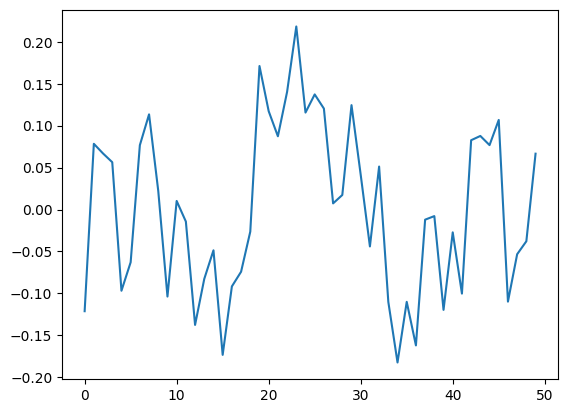

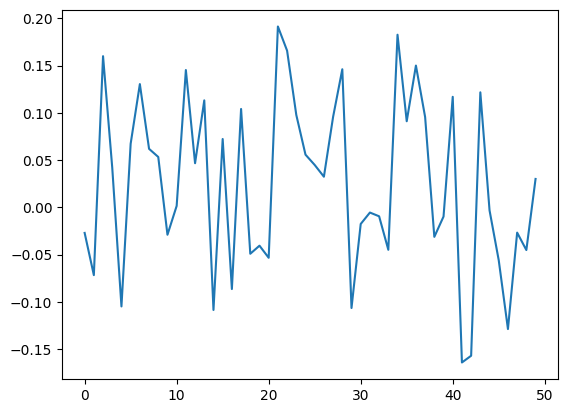

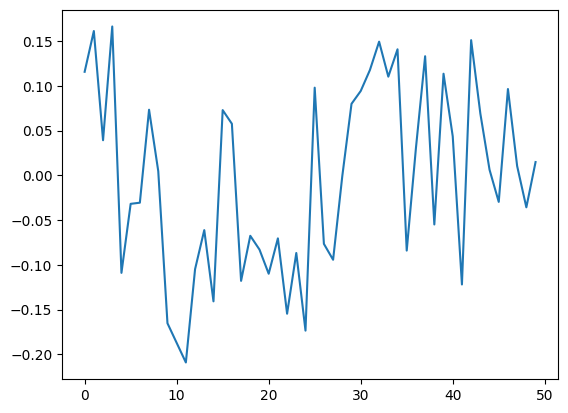

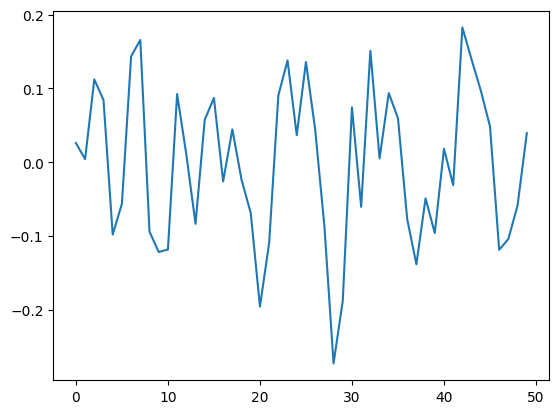

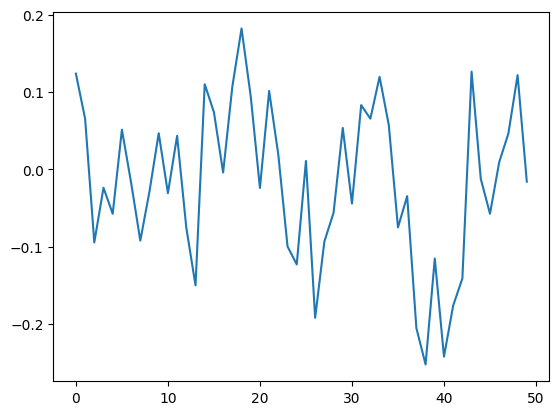

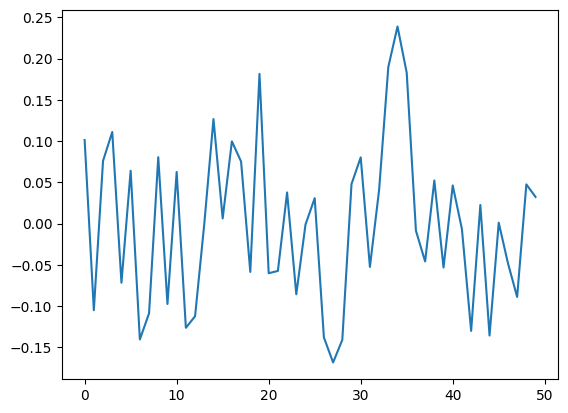

In [150]:
for param in model.parameters():
    print(param.data.shape)
    time_filters = param.data.cpu().numpy()
    break

for i in range(16):
    plt.plot(time_filters[i,0,0,:])
    plt.show()

In [27]:
model

ATCNet(
  (conv_block): Sequential(
    (0): Conv2d(1, 16, kernel_size=(1, 50), stride=(1, 1), padding=same, bias=False)
    (1): BatchNorm2d(16, eps=False, momentum=0.1, affine=True, track_running_stats=True)
    (2): Conv2d(16, 32, kernel_size=(12, 1), stride=(1, 1), groups=16)
    (3): BatchNorm2d(32, eps=False, momentum=0.1, affine=True, track_running_stats=True)
    (4): ELU(alpha=1.0)
    (5): AvgPool2d(kernel_size=(1, 8), stride=(1, 8), padding=0)
    (6): Dropout2d(p=0.1, inplace=False)
    (7): Conv2d(32, 32, kernel_size=(1, 16), stride=(1, 1), padding=same, bias=False)
    (8): BatchNorm2d(32, eps=False, momentum=0.1, affine=True, track_running_stats=True)
    (9): ELU(alpha=1.0)
    (10): AvgPool2d(kernel_size=(1, 7), stride=(1, 7), padding=0)
    (11): Dropout2d(p=0.1, inplace=False)
  )
  (msa0): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=32, out_features=32, bias=True)
  )
  (msa_drop0): Dropout(p=0.3, inplace=False)
  (tcn0): Sequenti

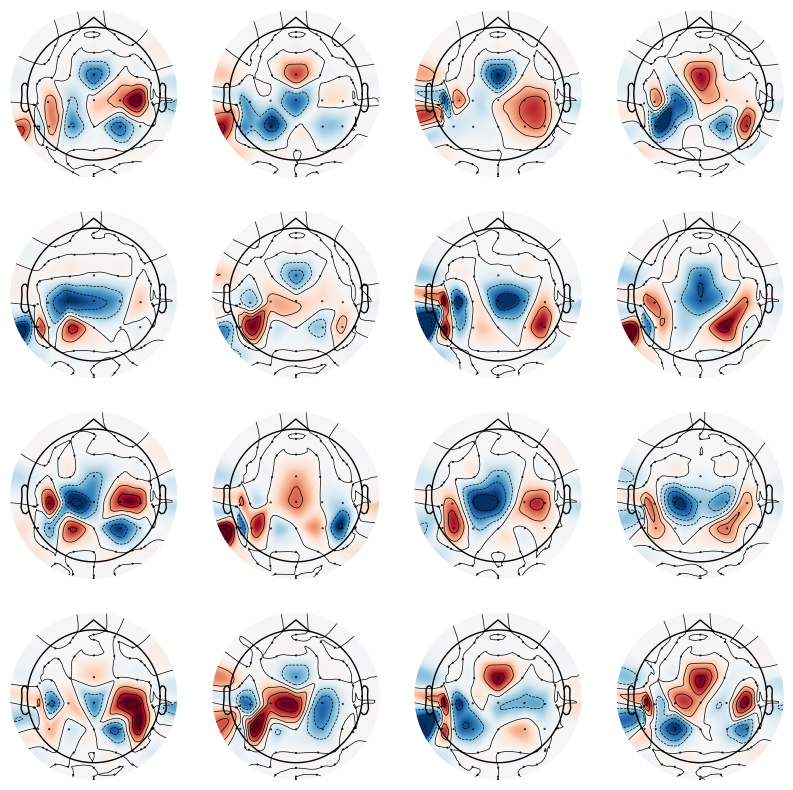

In [28]:
fig, ax = plt.subplots(4, 4, figsize=(10, 10))

for i in range(4):
    for j in range(4):
        spatial_map_12 = model.conv_block[2].weight.data[i + 4 * j].cpu().numpy().flatten()
        spatial_map_64 = np.zeros(64)
        spatial_map_64[list_idx_channels] = spatial_map_12
        mne.viz.plot_topomap(
            spatial_map_64,
            ch_positions[:, :2],
            show=False,
            axes=ax[i, j]
        )

plt.show()

# LDA / SVM

In [36]:
X_train = torch_trainset.features["band_psd"].reshape(torch_trainset.features["band_psd"].shape[0], -1)
y_train = torch_trainset.labels
X_test = torch_testset.features["band_psd"].reshape(torch_testset.features["band_psd"].shape[0], -1)
y_test = torch_testset.labels

# Train LDA classifier
lda_clf = LinearDiscriminantAnalysis()
lda_clf.fit(X_train, y_train)
y_pred = lda_clf.predict(X_test)
acc = np.mean(y_pred == y_test)
print("LDA accuracy: ", acc)

# Train SVM classifier
svm_clf = SVC(kernel='linear')
svm_clf.fit(X_train, y_train)
y_pred = svm_clf.predict(X_test)
acc = np.mean(y_pred == y_test)
print("SVM accuracy: ", acc)

# Train SVM classifier
svm_clf = SVC(kernel='rbf')
svm_clf.fit(X_train, y_train)
y_pred = svm_clf.predict(X_test)
acc = np.mean(y_pred == y_test)
print("rbf SVM accuracy: ", acc)

LDA accuracy:  0.66376217324449
SVM accuracy:  0.6688877498718606
rbf SVM accuracy:  0.6688877498718606


# Deep Fourier Transform

In [13]:
torch_trainset.features["time"].shape

torch.Size([2623, 641])

In [82]:
import importlib
importlib.reload(dataset)
importlib.reload(training)
importlib.reload(models)

<module 'eeg_project_package.models' from '/home/aurelien.stumpf/Development/BCI_Classification/eeg_project_package/models.py'>

In [12]:
torch_trainset.transform_dataset_numpy_to_torch()
torch_trainset.features["time"] = torch_trainset.features["time"][:,0,:].squeeze(1)
torch_testset.transform_dataset_numpy_to_torch()
torch_testset.features["time"] = torch_testset.features["time"][:,0,:].squeeze(1)

In [88]:
feature_type = "time"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = torch.nn.BCEWithLogitsLoss() #CrossEntropyLoss()
model = models.DeepWelchTransform(nperseg = 400, noverlap = 100, seq_length = 641)
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler1 = torch.optim.lr_scheduler.MultiplicativeLR(optimizer, lr_lambda=lambda epoch: 0.95)
scheduler2 = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5)
scheduler_dict = {"MultiplicativeLR":scheduler1} #, "ReduceLROnPlateau":scheduler2}
logs = training.train_model(model, trainloader, testloader, device, criterion, feature_type, 101, optimizer, scheduler_dict, print_epoch = 10)

Epoch 0:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 0
lr:  0.001
-------------------------
Train set: Avg. loss: 15.7218, Balanced Accuracy: 0.5009794235229492 (50%)
Test set: Avg. loss: 30.8711, Balanced Accuracy: 0.493813157081604 (49%)
-------------------------


Epoch 10:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 10
lr:  0.0005987369392383785
-------------------------
Train set: Avg. loss: 0.3076, Balanced Accuracy: 0.5089123249053955 (51%)
Test set: Avg. loss: 0.6126, Balanced Accuracy: 0.48246246576309204 (48%)
-------------------------


Epoch 20:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 20
lr:  0.0003584859224085418
-------------------------
Train set: Avg. loss: 0.0584, Balanced Accuracy: 0.5147550702095032 (51%)
Test set: Avg. loss: 0.0758, Balanced Accuracy: 0.49383360147476196 (49%)
-------------------------


Epoch 30:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 30
lr:  0.00021463876394293716
-------------------------
Train set: Avg. loss: 0.0515, Balanced Accuracy: 0.509131908416748 (51%)
Test set: Avg. loss: 0.0569, Balanced Accuracy: 0.49661195278167725 (50%)
-------------------------


Epoch 40:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 40
lr:  0.00012851215656510304
-------------------------
Train set: Avg. loss: 0.0477, Balanced Accuracy: 0.5033354759216309 (50%)
Test set: Avg. loss: 0.0538, Balanced Accuracy: 0.4906998574733734 (49%)
-------------------------


Epoch 50:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 50
lr:  7.69449752767131e-05
-------------------------
Train set: Avg. loss: 0.0461, Balanced Accuracy: 0.5 (50%)
Test set: Avg. loss: 0.0545, Balanced Accuracy: 0.5 (50%)
-------------------------


Epoch 60:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 60
lr:  4.606979898695191e-05
-------------------------
Train set: Avg. loss: 0.0450, Balanced Accuracy: 0.5 (50%)
Test set: Avg. loss: 0.0503, Balanced Accuracy: 0.5 (50%)
-------------------------


Epoch 70:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 70
lr:  2.758369043677494e-05
-------------------------
Train set: Avg. loss: 0.0447, Balanced Accuracy: 0.5 (50%)
Test set: Avg. loss: 0.0479, Balanced Accuracy: 0.5 (50%)
-------------------------


Epoch 74:   5%|▌         | 9/164 [00:00<00:03, 42.11batch/s, accuracy=0.613, loss=0.00276] 


KeyboardInterrupt: 

In [70]:
criterion.__class__.__name__

'BCEWithLogitsLoss'